Loaded 5 reference embeddings!


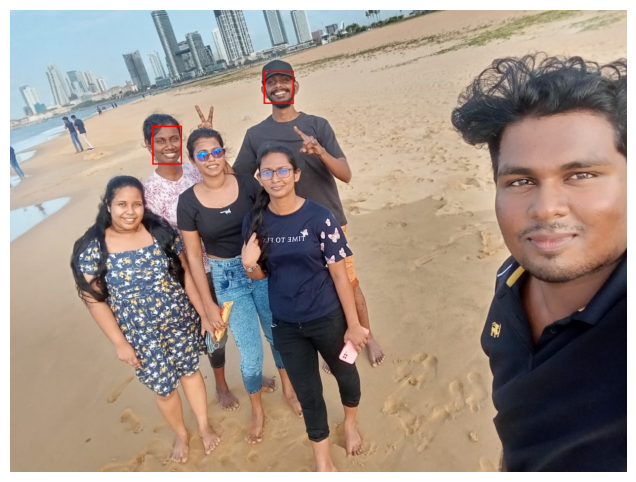

2 faces match the reference person!


In [69]:
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image, ImageDraw
from scipy.spatial.distance import cosine

# -----------------------------
# 1. Load Models
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mtcnn = MTCNN(keep_all=True, device=device)  # Detect multiple faces
facenet = InceptionResnetV1(pretrained="vggface2").eval().to(device)

# -----------------------------
# 2. Function to Get Face Embeddings (Ensure 4D Input)
# -----------------------------
def get_face_embedding(image):
    """Detects a face from an image and returns its embedding"""
    img_cropped = mtcnn(image)  # Detect faces and return cropped tensor

    if img_cropped is None:
        print("No face detected!")
        return None

    embeddings = []

    # Ensure each detected face is a 4D tensor
    if isinstance(img_cropped, torch.Tensor):
        if img_cropped.ndim == 3:  # If it's a single face, add batch dimension
            img_cropped = img_cropped.unsqueeze(0)  # Convert to batch format

        img_cropped = img_cropped.to(device)
        embedding = facenet(img_cropped).detach().cpu().numpy().flatten()

        if embedding.shape[0] == 512:  # Ensure correct shape
            embeddings.append(embedding)

    return embeddings  # Return list of embeddings

# -----------------------------
# 3. Load Multiple Reference Images (NO AVERAGING)
# -----------------------------
def get_all_reference_embeddings(image_paths):
    """Loads multiple reference images and stores individual embeddings"""
    embeddings = []

    for image_path in image_paths:
        image = Image.open(image_path)
        ref_embeddings = get_face_embedding(image)

        if ref_embeddings is not None:
            embeddings.extend(ref_embeddings)  # Collect all embeddings

    if len(embeddings) == 0:
        print("No valid reference embeddings found!")
        return None
    
    return embeddings  # Return list of embeddings instead of averaging

# Reference images list
reference_images = [
    "./face-resources/me1.jpg",
    "./face-resources/me2.jpg",
    "./face-resources/me3.jpg",
    "./face-resources/me4.jpg",
    "./face-resources/me5.jpg",
]

# Get all reference embeddings
reference_embeddings = get_all_reference_embeddings(reference_images)

if reference_embeddings is None:
    print("No valid reference images detected!")
else:
    print(f"Loaded {len(reference_embeddings)} reference embeddings!")

# -----------------------------
# 4. Recognize Person Using Nearest Reference Match
# -----------------------------
def recognize_person(image, reference_embeddings, threshold=0.5):
    """
    Detect faces in an image, compute their embeddings, and check if they match any reference embedding.
    """
    faces = mtcnn(image)  # Detect faces (returns cropped face tensors)

    if faces is None:
        print("No faces detected in the image.")
        return []

    detected_faces = []
    
    # Ensure output is always a list (even if there's only one face)
    if isinstance(faces, torch.Tensor):
        if faces.ndim == 3:
            faces = faces.unsqueeze(0)  # Convert to 4D tensor
    else:
        faces = [face.unsqueeze(0) for face in faces]

    for face in faces:
        face = face.to(device)  # Move to GPU/CPU

        # Ensure input is 4D
        if face.ndim == 3:
            face = face.unsqueeze(0)

        face_embedding = facenet(face).detach().cpu().numpy().flatten()

        # Ensure the shape is (512,)
        if face_embedding.shape[0] != 512:
            print("Skipping face due to incorrect embedding shape.")
            continue

        # Compare against each reference embedding & take the best match
        best_similarity = -1
        for ref_embedding in reference_embeddings:
            similarity = 1 - cosine(face_embedding, ref_embedding)

            if similarity > best_similarity:
                best_similarity = similarity  # Store highest similarity score
        
        if best_similarity > threshold:  # Check if best match is above threshold
            detected_faces.append(face_embedding)

    return detected_faces

# -----------------------------
# 5. Recognize & Highlight Detected Face(s)
# -----------------------------
def recognize_and_highlight(image_path, reference_embeddings, threshold=0.5):
    """
    Detect faces in an image, compute their embeddings, and highlight the recognized face.
    """
    # Load image
    image = Image.open(image_path)
    
    # Detect faces and bounding boxes
    boxes, _ = mtcnn.detect(image)

    if boxes is None:
        print("No faces detected in the image.")
        return
    
    # Convert image to draw on it
    draw = ImageDraw.Draw(image)

    # Detect and recognize faces
    faces = mtcnn(image)  # Cropped faces

    if faces is None:
        print("No faces detected.")
        return

    # Ensure output is always a list (even if there's only one face)
    if isinstance(faces, torch.Tensor):
        if faces.ndim == 3:
            faces = faces.unsqueeze(0)  # Convert to 4D tensor
    else:
        faces = [face.unsqueeze(0) for face in faces]

    detected_faces = 0

    for i, face in enumerate(faces):
        face = face.to(device)

        # Ensure input is 4D
        if face.ndim == 3:
            face = face.unsqueeze(0)

        face_embedding = facenet(face).detach().cpu().numpy().flatten()

        # Ensure embedding shape is (512,)
        if face_embedding.shape[0] != 512:
            print("Skipping face due to incorrect embedding shape.")
            continue

        # Compare against each reference embedding & take the best match
        best_similarity = -1
        for ref_embedding in reference_embeddings:
            similarity = 1 - cosine(face_embedding, ref_embedding)

            if similarity > best_similarity:
                best_similarity = similarity  # Store highest similarity score

        if best_similarity > threshold:  # Check if similarity is above threshold
            detected_faces += 1

            # Draw bounding box around the detected face
            x1, y1, x2, y2 = boxes[i]
            draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)

    # Display results
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    print(f"{detected_faces} faces match the reference person!")

# -----------------------------
# 6. Run Face Recognition with Improved Accuracy
# -----------------------------
recognize_and_highlight("./face-resources/gr9.jpg", reference_embeddings)